<a href="https://colab.research.google.com/github/stratos-karas/hello-world/blob/master/NN_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Στοιχεία Ομάδας**

**Ομάδα Μ.Β.25**
* Ονοματεπώνυμο: Καραπαναγιώτης Ευστράτιος
* Αριθμός Μητρώου: 03115177

# **Διάγραμμα ροής εκτέλεσης εργασιών**
<img src="https://drive.google.com/uc?id=1hbY83UBPULVGdhCc3oUAtXbLtDs_u2oE" width=100%>

#**Εισαγωγή απαραίτητων βιβλιοθηκών**

In [3]:
!pip install --upgrade somoclu

     |████████████████████████████████| 6.2MB 9.2MB/s 
  Created wheel for somoclu: filename=somoclu-1.7.5-cp36-cp36m-linux_x86_64.whl size=419306 sha256=2bc8a221d387189e8ef72481a663fdf25567be80fe0ff2ef725ef214b1b9acb5
  Stored in directory: /root/.cache/pip/wheels/85/3c/e5/5b1c535e93453367a8e3d35a377d3c668da00369b1a4302ad8
Successfully built somoclu


In [4]:
# Γενικά
import string

# Panda framework
import pandas as pd

# Numpy framework
import numpy as np
from numpy import dot
from numpy.linalg import norm

# Nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

# Lemmatizer / Stemmer
nltk.download('wordnet') 
nltk.download('rslp')
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# Sklearn framework
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Joblib framework
import joblib

# Somoclu framework
import somoclu

# Matplotlib
import matplotlib
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


# **$1^o$ Ζητούμενο**
<img src="https://drive.google.com/uc?id=1ptNaQPDT4oPLYbO4rbUTnQdDMz0AYp_z" width=100%>

Στο πρώτο μέρος της εργασίας ζητείται να παράξουμε ένα σύστημα συστάσεων ταινιών το οποίο θα βασίζεται στο περιεχόμενό τους. Τα δεδομένα τα παίρνουμε από το [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/) τα οποία συμπεριλαμβάνουν πληροφορίες όπως τίτλος, κατηγορίες και περιεχόμενο 40.000 ταινιών. Το σύστημά μας στηρίζεται στη διήθηση με βάση το περιεχόμενο όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο. Για να αποβεί σε ένα τέτοιο συμπέρασμα τα κείμενα περνούν από διάφορα στάδια προεπεξεργασίας, όπως τεμαχισμό, φιλτράρισμα άστοχων λέξεων, λημματοποίηση και άλλες τεχνικές για την εξαγωγή των κατάλληλων χαρακτηριστικών μέσω των οποίων θα αναπαρίστανται. Τα χαρακτηριστικά είναι λέξεις των κειμένων τα οποία έχουν επιλεχθεί με βάση τα προηγούμενα κριτήρια και με βάση κάποιες συχνότητες εμφάνισης που ορίζονται πειραματικά. Με τη βοήθεια του framework sklearn μετατρέπονται τα κείμενα πλέον σε διανύσματα πολλών διαστάσεων, όσο είναι και τα χαρακτηριστικά που έχουν εξαχθεί. Έτσι το σύστημα μπορεί αν συγκρίνει πλέον με μαθηματικούς όρους τις ταινίες με βάση το περιεχόμενό τους. 

## **Εισαγωγή Δεδομένων**

In [0]:
dataset_url = "https://drive.google.com/uc?export=download&id=1PdkVDENX12tQliCk_HtUnAUbfxXvnWuG"

df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3, error_bad_lines=False)

In [0]:
# Ο αριθμός seed της ομάδας
team_seed_number = 40

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1RRoiOjhD0JB3l4oHNFOmPUqZHDphIdwL"

df_data_2 = pd.read_csv(movie_seeds_url, header=None, error_bad_lines=False)

# Επιλέγονται οι κατάλληλοι δείκτες - ταινίες - με βάση τον αριθμό seed της ομάδας 
indexes = df_data_2.iloc[team_seed_number,:].values

# Οι τίτλοι των ταινιών
titles = df_data_1.iloc[:, [2]].values[indexes]

# Οι κατηγορίες (τα είδη) της κάθε ταινίας
categories = df_data_1.iloc[:, [3]].values[indexes]

# Οι κατηγορίες εκφρασμένες σε δυαδική μορφή
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[indexes] # movie categories in binary form (1 feature per category)

# Οι περιλήψεις της κάθε ταινίας εκφρασμένες σε φυσική γλώσσα
# Ο πίνακας περιλήψεων
summaries =  df_data_1.iloc[:, [5]].values[indexes]
# Λίστα περιλήψεων
corpus = summaries[:,0].tolist()

## **Προεπεξεργασία**

Στο σημείο αυτό με μια αναζήτηση στο ιντερνετ αναζητούμε λέξεις που χρησιμοποιούνται συχνά στις περιλήψεις ταινιών για να τις αποφύγουμε στη εξαγωγή ομοιότητας.

In [0]:
common_words = ['story', 'plot', 'premise', 'film', 'protagonist', 'protagonists', 'character', 'characters',
                'prequel', 'sequel', 'adults-only', 'exciting', 'breathtaking', 'trilogy', 'production', 'original', \
                'remake', 'role', 'roles', 'director', 'producer', 'soundtrack', 'cinematography', 'customes', 'screenplay',
                'classics', 'located', 'placed', 'stage', 'effects', 'adaptation', 'critics', 'reviewers', 'oscar']

Επίσης θα χρησιμοποιήσουμε μια βάση αγγλικών ονομάτων για να αφαιρέσουμε τα ονόματα των χαρακτήρων από τη διαδικασία εύρεσης ομοιότητας μεταξύ των περιλήψεων.

In [0]:
fd_names = pd.read_csv("https://raw.githubusercontent.com/smashew/NameDatabases/master/NamesDatabases/first%20names/us.txt")

In [0]:
# Μετατρέπουμε τα ονόματα σε πεζά καθώς η διαδικασία tokenizing μετατρέπει όλα
# τα κείμενα περιλήψεων σε πεζά για να εξάγει τις λέξεις
given_names = [name[0].lower() for name in fd_names.values]

In [0]:
# Λίστα με όλες τις λέξεις που πρέπει να φιλτράρει ο tokenizer
avoid_list = stopwords.words('english') + list(string.punctuation) + common_words + given_names

In [0]:
# Με το φίλτρο αυτό αφαιρούμε οποιοδήποτε σημείο στίξης
# δε θα καταφέρει να αφαιρέσει το πρώτο επίπεδο φιλτραρίσματος
# του συστήματος προεπεξεργασίας μέσω του avoid list
def thorough_filter(words):
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in string.punctuation)
        if not all(pun):
            filtered_words.append(word)
    return filtered_words

In [0]:
# Αρχικοποιούμε τα απαραίτητα για την λημματοποίηση
wordnet_lemmatizer = WordNetLemmatizer()
# και αφαίρεση κατάληξης αντίστοιχα
porter_stemmer = PorterStemmer()

In [0]:
# Τμηματοποίηση περιλήψεων με λημματοποίηση των λέξεων
def lemmatizing_tokenizer(summary):
  tokenized_summary = nltk.word_tokenize(summary.lower())
  filtered_summary = [word for word in tokenized_summary if word not in avoid_list]
  filtered_summary = thorough_filter(filtered_summary)
  lemmatized_summary = [wordnet_lemmatizer.lemmatize(word) for word in filtered_summary]
  return lemmatized_summary

In [0]:
# Τμηματοποίηση περιλήψεων με αφαίρεση καταλήξεων από τις λέξεις 
def stemming_tokenizer(summary):
  tokenized_summary = nltk.word_tokenize(summary.lower())
  filtered_summary = [word for word in tokenized_summary if word not in avoid_list]
  filtered_summary = thorough_filter(filtered_summary)
  stem_summary = [porter_stemmer.stem(word) for word in filtered_summary]
  return stem_summary

Παρατηρήσαμε πειραματικά ότι η λημματοποίηση (lemmatizing) επιστρέφει καλύτερα ως προς τη σημασιολογία αποτελέσματα από την αφαίρεση κατάληξης (stemming). Για το λόγο αυτό στη συνέχεια θα εμείνουμε στη τεχνική λημματοποίησης και θα προσπαθήσουμε να την βελτιστοποιήσουμε.

In [50]:
# Με το TfidfVectorizer μπορούμε να εφαρμόσουμε όλα τα στάδια προεπεξεργασίας
# στο στάδιο tokenizing που προσφέρει το framework
vec = TfidfVectorizer(decode_error='ignore', tokenizer=lemmatizing_tokenizer, analyzer='word',\
                      max_df=0.9, min_df=4, max_features=3500)

%time corpus_tf_idf = vec.fit_transform(corpus).toarray()

CPU times: user 1min 8s, sys: 92.9 ms, total: 1min 8s
Wall time: 1min 8s


In [51]:
# Εκτυπώνουμε τις διαστάσεις του corpus_tf_idf αρχείου
print(corpus_tf_idf.shape)

(5000, 3500)


Με το max_df=0.9 περιορίσαμε τις πολύ συχνά εμφανιζόμενες στα κείμενα λέξεις. Χαμηλότερες τιμές δεν βελτίωναν τις διαστάσεις. Με το min_df αφαιρέσαμε τις λέξεις που εμφανίζονται λιγότερο από 4 φορές στα κείμενα. Παραπάνω από αυτό τον αριθμό τα αποτελέσματα χειροτερεύαν. Εφαρμόσαμε max_feaures προκειμένου να μη ξεφύγει το πλήθος των χαρακτηριστικών που θα χρησιμοποιηθούν για την εξαγωγή ομοιότητας μεταξύ των περιλήψεων. Χωρίς εφαρμογή των max_features θα είχαμε 10967 χαρακτηριστικά. 

In [0]:
# Εξάγουμε-αποθηκεύουμε το corpus_tf_idf αρχείο σε pkl μορφή 
joblib.dump(tf_idf, 'corpus_tf_idf_lemm_3500.pkl')

## **Εφαρμογή Συστήματος και Αποτελέσματα**

Στο σημείο αυτό έχουμε μετατρέψει την περίληψη κάθε ταινίας σε ένα διάνυσμα. Μιλάμε για έναν διανυσματικό χώρο πολλών διαστάσεων στον οποιόν όμως είναι καλά ορισμένη η πράξη εσωτερικού γινομένου. Μπορούμε πλέον να εφαρμόσουμε τεχνικές εύρεσης ομοιότητας βασιζόμενες στα μαθηματικά. Εμείς θα χρησιμοποιήσουμε τη τεχνική της ομοιότητας συνημιτόνου. Άν έχουμε δύο περιλήψεις οι οποίες έχουν διανυσματική αναπαράσταση $\vec{A}$ και $\vec{B}$ αντίστοιχα, τότε η ομοιότητα συνημιτόνου ορίζεται ως το μέτρο:

$$ similarity = cos(\theta) = \frac{\vec{A} \vec{B}}{||\vec{A}|| ||\vec{B}||} = \frac{\sum_{i=1}^{n}{A_i B_i}}{\sqrt{\sum_{i=1}^{n}A_i^2}\sqrt{\sum_{i=1}^{n}B_i^2}} $$

Αν το μέτρο είναι 0 τότε σημαίνει ότι τα διανύσματα είναι κάθετα και έτσι οι περιλήψεις των ταινιών σημασιολογικά δεν παρουσιάζουν ομοιότητα. Αν το μέτρο είναι 1 τότε σημαίνει ότι τα διανύσματα στο χώρο είναι παράλληλα και επομένως η σημασιολογία των δύο περιλήψεων ταυτίζεται.

In [0]:
def content_recommender(target_id, max_recommendations):
  # Το πλήθος των ταινιών
  n_movies = len(corpus_tf_idf)

  # Δημιουργούμε ένα πίνακα μηδενικών για να
  # αποθηκεύσουμε τους δείκτες ομοιότητας
  similarities = np.zeros(n_movies)

  # Εφαρμόζουμε το μαθηματικό τύπο που περιγράφεται παραπάνω
  for i in range(n_movies):
    similarities[i] = dot(corpus_tf_idf[target_id], corpus_tf_idf[i]) / (norm(corpus_tf_idf[target_id]) * norm(corpus_tf_idf[i])) 

  # Ταξινομούμε κατα 
  idxs = np.argsort(-similarities)

  return idxs[1:max_recommendations+1]

Στο σημείου αυτό χρησιμοποιούμε το παρακάτω μπλόκ κώδικα προκειμένου να βρούμε ταινίες που γνωρίζουμε μέσα στο σύνολο ταινιών που μας έτυχαν. Βοηθάει στο να εξάγουμε σύντομα συμπέρασμα σχετικά με την αποδοτικότητα του συστήματός μας.

In [21]:
i = 0
for x in titles:
  if "Fast" in list(x)[0]:
    print("yes, ", i, titles[i])
  i = i+1

yes,  444 ['Fast Track']
yes,  643 ['The Fast Lady']
yes,  1453 ['Fast Girls']
yes,  1548 ['Fast Food Nation']
yes,  1825 ['Fast Life']
yes,  1854 ['Fast Company']
yes,  1860 ['Turtles Are Surprisingly Fast Swimmers']
yes,  3895 ['Tom & Jerry and the Fast and the Furry']
yes,  4993 ['The Fast and the Furious']


**Αυτή η λίστα είναι γνωστές σε εμας ταινίες:**
* 3571 Pirates of the Caribbean: The Curse of the Black Pearl

* 273 Transformers: Dark of the Moon

* 4785 Three Idiots

* 1984 Indiana Jones and the Temple of Doom

* 3161 Kill Bill Volume 1

* 1722 The Girl with the Dragon Tattoo

* 1563 Bleach: Fade to Black, I Call Your Name

* 1595 Monty Python's The Meaning of Life

* 560 Harry Potter and the Prisoner of Azkaban

* 868 Harry Potter and the Chamber of Secrets

* 2670 Harry Potter and the Order of the Phoenix

* 499 Camelot

* 4993 The Fast and the Furious

* 310 Hansel and Gretel

In [0]:
# Συνάρτηση που παρουσιάζει μέσα σε ένα παραλληλόγραμμο
# τη συμβολοσειρά που θέτουμε ως παράμετρο
def beautify_text(text):
  
  augmented_text = "* " + text + " *"
  
  for i in augmented_text:
    print('*', end='')
  print()
  
  print(augmented_text)
  
  for i in augmented_text:
    print('*', end='')
  print()

# Οπτικοποίηση πληροφοριών για την ταινία στόχο
def movie_infos_display(id, presentation="Recommended movie"):
  beautify_text(presentation)
  print("* Id of the movie: ", id)
  print("* Title of the movie: ", titles[id][0])
  print("* Categories of the movie: ", categories[id][0].replace('"', ''))
  print("* Summary of the movie:")
  print(summaries[id][0])
  print()

In [23]:
target_id = 1722
idxs = content_recommender(target_id, 5)

movie_infos_display(target_id, "Target movie")

for i in idxs:
  movie_infos_display(i)

****************
* Target movie *
****************
* Id of the movie:  1722
* Title of the movie:  The Girl with the Dragon Tattoo
* Categories of the movie:  Crime Fiction,  Thriller,  Detective fiction,  World cinema,  Detective,  Mystery,  Crime Thriller
* Summary of the movie:
In December 2002, Mikael Blomkvist , publisher of Millennium magazine, loses a libel case involving allegations he published about billionaire financier Hans-Erik Wennerström . He is sentenced to three months  in prison, and ordered to pay hefty damages and costs. Lisbeth Salander , who is a surveillance agent has been contracted to investigate Blomkvist by a lawyer, Dirch Frode , on behalf of his sole client, Henrik Vanger , the elderly patriarch of the wealthy Vanger family. Before the publisher is imprisioned, Vanger hires Blomkvist to investigate the disappearance of his great-niece, Harriet, who vanished on Children's Day in 1966. Vanger believes that Harriet was murdered by a family member. When Salande

3099
999
199
399

**Ταινίες που έβγαλαν καλά αποτελέσματα:**
* **Pirates of the Caribbean: The Curse of the Black Pearl (ID = 3571)**
    > *Παρόμοιες Ταινίες:*
      1. Treasure Island
      2. Scooby-Doo! Pirates Ahoy!
      3. Animal Treasure Island
      4. Mysterious Island
      5. The Lost Continent
    >*Λέξεις-κλειδιά*:
      1. pirate
      2. treasure
      3. ship
      4. vessel
      5. island

* **Transformers: Dark of the Moon (ID = 273)**

  > *Παρόμοιες Ταινίες:*
      1. Battle in Outer Space
      2. Can Of Worms
      3. Journey to Saturn
      4. Babylon 5: In the Beginning
      5. Battlefield Earth
  >*Λέξεις-κλειδιά*:
      1. earth
      2. space
      3. ship
      4. alien
      5. war

* **The Girl with the Dragon Tattoo (ID = 1722)**

  > *Παρόμοιες Ταινίες:*
      1. Battle in Outer Space
      2. Can Of Worms
      3. Journey to Saturn
      4. Babylon 5: In the Beginning
      5. Battlefield Earth
  >*Λέξεις-κλειδιά*:
      1. earth
      2. space
      3. ship
      4. alien
      5. war
*

# **$2^o$ Ζητούμενο**
<img src="https://doc-0g-64-docs.googleusercontent.com/docs/securesc/4mct394hfic4sigv0sbv8fbghf3se06j/qh7bj0k6ljtp6v9rnfr77i3rhuhbd70m/1579816800000/10294228830746280044/10294228830746280044/19i8UsZDc5zN_xGbnNWxu4BzGVYCf_tWk?authuser=0&nonce=cdmqpjmjfi42e&user=10294228830746280044&hash=lci6eltqn6fh1scbioh3i9l7c3ih9f4p" width=100%>

Στο δεύτερο μέρος της εργασίας επικεντρωνόμαστε στη σημασιολογική απεικόνιση των ταινιών με χρήση του νευρωνικού δικτύου SOM. Πιο αναλυτικά, προσθέτουμε στην απεικόνιση διανυσμάτων που εξάγαμε στο πρώτο μέρος και τις κατηργορίες που ανήκουν οι ταινίες σε δυαδική μορφή και προσπαθούμε να απεικονίσουμε ένα πεπερασμένο σύνολο νευρώνων (som) στην είσοδο. Με άλλα λόγια εξάγουμε χαρακτηριστικά (διακριτοποιούμε την είσοδο) και τα προβάλλουμε πάνω σε έναν χάρτη.

Με κοκκινοπό χρώμα στο χάρτη απεικονίζονται ταινίες οι οποίες το περιεχόμενο και το είδος τους απέχουν πολύ. Με πράσινο-μπλέ χρώμα παρουσιάζονται τα σημεία-ταινίες τα οποία σημασιολογικά είναι κοντά και έτσι σχηματίζουν ομάδες(clusters). 

Στο πρώτο κομμάτι αυτής της ενότητας παρουσιάζεται η δομή του Som, δηλώνονται οι συναρτήσεις παραγωγής αναφορών και βγαίνουμε σε συμπεράσματα. Στο δεύτερο κομμάτι παρουσιάζουμε μετρικές εμπιστοσύνης-απόφασης για την ποιότητα απεικόνισης και ομαδοποίησης και βελτιστοποιούμε το χάρτη. 

In [0]:
# Σε περίπτωση που έχουμε χάσει το session
# μπορούμε να ξαναφορτώσουμε τη διανυσματική απεικόνιση των περιλήψεων
corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')

![](https://drive.google.com/uc?id=10D6TAUW4YcJpNEfijuLzt5EvREZuD5Z0)

In [0]:
# Με τη βοήθεια της συνάρτησης αυτής μπορούμε να μετατρέψουμε
# τη διανυσματική απεικόνιση corpus από αραιή σε πυκνή
# και να προσθέσουμε τα είδη των ταινιών
def build_final_set(corpus_tf_idf, doc_limit = 5000, tf_idf_only=False):
    # Μετατροπή tf_idf από αραιό πίνακα σε πυκνό
    dense_tf_idf = corpus_tf_idf[0:doc_limit,:]
    if tf_idf_only:
        # Αν δε μας ενδιαφέρουν οι κατηγορίες των ταινιών
        # επιστρέφουμε μόνο την πυκνή αναπαράσταση 
        final_set = dense_tf_idf
    else:
        # Διαφορετικά προσθέτουμε τις κατηγορίες σε δυαδική αναπαράσταση
        # οριζοντίως του πυκνού (πλέον) πίνακα χαρακτηριστικών
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
        # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

In [0]:
final_set = build_final_set(corpus_tf_idf)

In [27]:
final_set.shape

(5000, 3822)

## **Σύστημα Αναφορών και Αποφάσεων**

### **Δηλώσεις Συναρτήσεων Εξαγωγής Χαρακτηριστικών**

Τα χαρακτηριστικά που θα πρέπει να εξαχθούν για το σύστημα είναι:

  1. ο αριθμός των νευρώνων που ανήκουν στις ομάδες
  2. το πλήθος των ταινιών που αντιστοιχίζονται σε κάθε νευρώνα
  3. το σύνολο των ταινιών που ανήκουν στις ομάδες 
  4. τα είδη ταινιών που κυριαρχούν στις ομάδες

In [0]:
'''
++++++++++++++++++++++++++
+ print_categories_stats +
++++++++++++++++++++++++++
  + movie_ids:
  + max_cats:
'''
# Εκτυπώνει από μια λίστα ids ταινιών τη συχνότητα εμφάνισης
# της κάθε κατηγορίας των ταινιών

def print_categories_stats(movie_ids, max_cats=-1):

  all_movies_categories = []

  for id in movie_ids:
    '''
      Για κάθε ταινία με id χωρίζουμε τις κατηγορίες
      σε μια λίστα και βγάζουμε από κάθε λέξη-κατηγορία
      τα διπλά εισαγωγικά
    '''
    categorieslist = categories[id][0].split(',')
    categorieslist = [category.strip().strip('"') for category in categorieslist]
    
    '''
      Στη συνέχεια υπάρχουν κατηγορίες που απαντώνται σε μία
      μόνο λέξη με το συνδετικό χαρακτήρα "/", οπότε το αφαιρούμε
      και κρατάμε τις θεμελιώδεις κατηγορίες που απαρτίζουν τον όρο
    '''
    auxlist = []
    for category in categorieslist:
      if '/' in category:
        auxlist.extend(category.split('/'))
      else:
        auxlist.append(category)

    all_movies_categories.extend(auxlist)

  # Μετατρέπουμε τη λίστα σε πίνακα για να εκτελέσουμε
  # τις επόμενες ενέργειες
  all_movies_categories = np.asarray(all_movies_categories)
  
  # Μοναδικές τιμές και πόσες φορές εμφανίζονται
  all_movies_categories, times = np.unique(all_movies_categories,return_counts=True)

  # Ταξινόμηση κατηγοριών με βάση τη συχνότητα εμφάνισης
  sorting_idcs = np.argsort(-times)

  # Παρουσίαση αποτελεσμάτων
  if max_cats < 0:
    for idx in sorting_idcs:
      print(all_movies_categories[idx], times[idx])
  else:
    for idx in sorting_idcs[:max_cats]:
      print(all_movies_categories[idx], times[idx])

  # Επιστρέφουμε τις δύο σημαντικότερες κατηγορίες που εμφανίζονται σε αυτή τη λίστα
  # ταινιών για να τις χρησιμοποιήσουμε ως labels
  # στον πίνακα Umatrix
  return [all_movies_categories[idx] for idx in sorting_idcs[:3]]

In [0]:
'''
++++++++++++++++++++++++++++++++
+ print_cluster_neurons_movies +
++++++++++++++++++++++++++++++++
  + cluster_id:
  + clusters:
'''

# Δέχεται ως όρισμα το αναγνωριστικό ενός cluster
# και επιστρέφει τις συντεταγμένες των νευρώνων που ανήκουν σε αυτό

def print_cluster_neurons_movies(bmus, clusters, cluster_id):
  # Αρχικοποιούμε τη λίστα με τους νευρώνες
  neurons = []

  # Παίρνουμε τις γραμμές και στήλες για τους νευρώνες
  # που ανήκουν στο cluster με αναγνωριστικό cluster_id
  row_idcs, col_idcs = np.where(clusters == cluster_id)

  # Σαρώνουμε όλες τις συντεταγμένες των νευρώνων που ανήκουν
  # στο cluster
  for row_idx, col_idx in zip(row_idcs, col_idcs):
    # Μετατρέπουμε τις συντεταγμένες σε πίνακα μορφή συγκρίσιμη
    # με τον πίνακα των bmus για να ελέγξουμε τη συνέπεια
    neuron = np.asarray([col_idx, row_idx])

    # Αν ο νευρώνας ανήκει στον πίνακα των bmus τότε τοποθέτησε
    # στη λίστα νευρώνων
    if neuron in bmus:
      neurons.append(neuron)

  return neurons

In [0]:
'''
++++++++++++++++++++++++
+ neuron_movies_report +
++++++++++++++++++++++++
  + neurons:
  + verbose:
  + general:
  + special:
'''
def neuron_movies_report(neurons, bmus, verbose=True, special=False, general=False):

  movie_ids = []

  # Για το test εξειδίκευσης
  unused_neurons = 0
  specializing_cluster = False
  # Για το test γενίκευσης
  counter_list = []
  generalizing_cluster = False

  if verbose == True:
    beautify_text("Αριθμός BMUs: {}".format(len(neurons)))

  # Μετατροπή του πίνακα bmus σε λίστα
  bmus_list = list( map(lambda x: list(x), list(bmus)) )

  for neuron in neurons:
    # Μετρητής ταινιών για κάθε νευρώνα ξεχωριστά
    counter = 0
    
    # Μετατροπή της απεικόνισης του νευρώνα από
    # πίνακα σε λίστα
    neurli = list(neuron)
    
    # Αναζήτηση στη λίστα bmus για το ποιές ταινίες
    # αντιστοιχίζονται στο νευρώνα
    for idx in range(5000):
      if bmus_list[idx] == neurli:
        # Αν βρέθηκε τότε αποθήκευσε το δείκτη της ταινίας
        movie_ids.append(idx)
        # και αύξησε το counter
        counter += 1

    if verbose == True:
      print("Νευρώνας({}, {}) με {} ταινίες".format(neuron[1], neuron[0], counter))

    # Αν ένας νευρώνας δεν έχει ταινίες που να αντιστοιχίνται
    # σε αυτόν τότε αύξησε τον αριθμό των "άχρηστων" νευρώνων
    if special == True:
      if counter == 0:
        unused_neurons += 1

    if general == True:
      counter_list.append(counter)

  # Αριθμός ταινιών που έχουν ανατεθεί στο cluster
  if verbose == True:
    beautify_text("Αριθμός ταινιών: " + str(len(movie_ids)))

  # Test εξειδίκευσης
  if special == True:
    if unused_neurons >= len(neurons)/2:
      specializing_cluster = True

  # Test γενίκευσης
  if general == True:
    if np.var(np.asarray(counter_list)) <= 1:
      generalizing_cluster = True
  
  if special == True:
    if general ==  True:
      return movie_ids, specializing_cluster, generalizing_cluster
    else:
      return movie_ids, specializing_cluster
  else:
    if general == True:
      return movie_ids, generalizing_cluster

  return movie_ids

In [0]:
'''
++++++++++++++++++++++++
+ neuron_movies_report +
++++++++++++++++++++++++
  + neurons:
  + verbose:
  + general:
  + special:
'''
# Συνάρτηση για τη δημιιυργία ετικετών που θα χρησιμοποιηθούν
# στην απεικόνιση του Umatrix
def create_labels(bmus, clusters, num_clusters, genre_labels, counts):

  labels = []
  
  cluster_categories = list(['nan' for i in range(num_clusters)])
  
  cluster_labels_counters = np.zeros(num_clusters)
  
  for _, bmu in enumerate(bmus):
    
    col, row = bmu
    
    cluster_idx = clusters[row][col]

    genres = genre_labels[cluster_idx]

    genre_labels[cluster_idx] = ''

    if genres != '':
      labels.append("Cluster" + str(cluster_idx) + ":\n" + genres)
      cluster_labels_counters[cluster_idx] += 1
    else:
      if cluster_labels_counters[cluster_idx] > counts:
        labels.append("")
      else:
        labels.append(str(cluster_idx))
        cluster_labels_counters[cluster_idx] += 1

  return labels

In [0]:
def print_cluster_neurons_movies_report(bmus, clusters, num_clusters):
  for idx in range(num_clusters):
    print("Cluster {}".format(idx))
    neurons_list = print_cluster_neurons_movies(bmus, clusters, idx)
    movie_ids = neuron_movies_report(neurons_list, bmus)
    print()

### **Δηλώσεις Συναρτήσεων Εξαγωγής Αποφάσεων**

Για την βελτιστοποίηση του συστήματος (της σημασιολογικής απεικόνισης των ταινιών σε χάρτη) θα πρέπει να λάβουμε αποφάσεις για αυτό με κάποιες μετρικές. Για το λόγο αυτό συνθέτουμε για κάθε μια τεστ που θα επιστρέφουν τις τιμές τους:

* **Test εξειδίκευσης:** το ποσοστό των bmus που υπάρχουν σε μια ομάδα(cluster) αλλά δεν τους έχει ανατεθεί ταινία.
* **Test γενίκευσης:** έλεγχος της απόκλισης μεταξύ των bmus σε μια ομάδα. Αν όλα τα bmus δεν έχουν μεγάλη απόκλιση στο πλήθος των ταινιών τότε η ομάδα γενικεύει επικίνδυνα.
* **Top 5 categories test:** έλεγχος για το αν ταινίες που έχουν ομαδοποιηθεί κάτω από την ίδια ομάδα παρουσιάζουν κατηγορίες που βγάζει νόημα σημασιολογικά να είναι στην ίδια ομάδα.
* **Test γειτόνων:** έλεγχος για το κατα πόσο οι ταινίες που βρίσκονται σε άλλες ομάδες και γειτνιάζουν με την ομάδα ενδιαφέροντος είναι σημασιολογικά και ως προς τα είδη "συγγενικές". Η μετρική αυτή εκφράζει ουσιαστικά το θόρυβο μεταξύ των δειγμάτων και της διαδικασίας ομαδοποίησης αυτών.
* **Test συγχώνευσεως:** το ποσοστό των ομάδων που θα μπορούσαν να συγχωνευτούν κάτω από μια ομάδα.

In [0]:
# Συνάρτηση για την εκτέλεση του test εξειδίκευσης
def specialization_test(specializing_report, num_clusters):
  num_specializing_clusters = len( list( filter(lambda x: x == True, specializing_report) ) )
  print("Ποσοστό εξειδικευμένων ομάδων: {}%".format(num_specializing_clusters / num_clusters * 100))

In [0]:
# Συνάρτηση για την εκτέλεση του test γενίκευσης
def generalization_test(generalizing_report, num_clusters):
  num_generalizing_clusters = len( list( filter(lambda x: x == True, generalizing_report) ) )
  print("Ποσοστό γενικευμένων ομάδων: {}%".format(num_generalizing_clusters / num_clusters * 100))

In [0]:
# Συνάρτηση για την εκτέλεση του test συγχώνευσης
def merging_test(merge_labels, num_clusters):

  merge_counts = np.zeros(num_clusters)

  # Για κάθε ομάδα
  for i in range(num_clusters):
    # Σύγκρινέ την με οποιαδήποτε άλλη πλην του εαυτού της
    for j in range(i+1, num_clusters):
      # Αποθήκευε έναν μετρητή για το πόσες κοινές κατηγορίες μοιράζονται
      # οι δύο άγνωστες μεταξύ τους ομάδες
      counter = 0
    
      # Για κάθε κατηγορία στην πρώτη ομάδα
      # έλεγξε αν υπάρχει και στη προς σύγκριση
      for cat in merge_labels[i]:
        if cat in merge_labels[j]:
          counter += 1
    
      # Αν το πλήθος των κοινών κατηγοριών ξεπερνάει
      # τις μισές κατηγορίες τότε αυτές οι δύο ομάδες θα μπορούσαν
      # κάλλιστα να συγχωνευθούν σε μία
      if counter >= len(merge_labels[j])/2:
        merge_counts[i] += 1

  # Με αυτή την γραμμή υπολογίζουμε το άθροισμα της λίστας μοναδικών τιμών
  # που εμφανίζονται παραπάνω από μία φορά στον counts (εξού και το -1)
  # για να παράξουμε το πλήθος των δυνατών συγχωνεύσεων
  num_of_merges = sum( list(filter(lambda x: x>0, merge_counts.tolist())) )

  # Τυπώνουμε το ποσοστό των επιτρεπτών συγχωνεύσεων μεταξύ των ομάδων
  print("Ποσοστό επιτρεπτών συγχωνεύσεων: {}%".format(num_of_merges/num_clusters * 100))

In [0]:
def top5_categories_test(top5list, num_clusters):
  passed = len( [x for x in top5list if x == 1] )
  print("Ποσοστό ομάδων που πέρασαν το τεστ των Top5 κατηγοριών: {}%".format(100 * passed / num_clusters))

In [0]:
def neighbors_test(neighbors_noise, num_clusters):
  sum_noise = sum(neighbors_noise)
  print("Ποσοστό θορύβου μεταξύ των γειτονικών ομάδων: {}%".format(100 * sum_noise/num_clusters))

In [0]:
'''
+++++++++++++
+ all_tests +
+++++++++++++
  + bmus:
  + num_clusters:
  + clusters:
'''
def all_tests(bmus, clusters, num_clusters, counts):
  genre_labels = []
  merge_labels = []
  specializing_report = []
  generalizing_report = []
  
  for idx in range(num_clusters):
    # Εκτύπωση στοιχείων της ομάδας (cluster)
    print("Cluster {}".format(idx))
    print("^^^^^^^^^^")
  
    # Νευρώνες νικητές που ανήκουν στην ομάδα (cluster)
    neurons_list = print_cluster_neurons_movies(bmus, clusters, idx)
  
    # Αναγνωριστικά ταινιών που ανήκουν στο cluster
    movie_ids, speccl, gencl = neuron_movies_report(neurons_list, bmus, verbose=False,\
                                                    special=True, general=True)
  
    # Αναφορά ευρημάτων για εξειδίκευση
    specializing_report.append(speccl)

    # Αναφορά ευρημάτων για γενίκευση
    generalizing_report.append(gencl)

    print()
  
    # Συχνότητες εμφάνισης κατηγοριών στην ομάδα
    genres = print_categories_stats(movie_ids, 5)

    # Δημιουργία λίστας ετικετών για την απεικόνιση στο Umatrix  
    genre_labels.append(genres[0] + ",\n" + genres[1] + ",\n" + genres[2])
  
    # Δημιουργία λίστας ετικετών για την αναφορά συγχωνεύσεων
    merge_labels.append(genres) 
  
    print()

  # Test Εξειδίκευσης
  specialization_test(specializing_report, num_clusters)

  # Test Γενίκευσης
  generalization_test(generalizing_report, num_clusters)

  # Test συγχωνεύσεως
  merging_test(merge_labels, num_clusters)

  # Δημιουργία Ετικετών για το Umatrix
  return create_labels(bmus, clusters, num_clusters, genre_labels, counts)

## **Καμμία βελτιστοποίηση**

### **SOM init&train / SOM load**

In [0]:
# Οι διαστάσει του χάρτη
cols, rows = 10, 10

In [0]:
som = somoclu.Somoclu(n_columns=cols, n_rows=rows, maptype='planar')

In [29]:
%time som.train(final_set, epochs=100)

CPU times: user 10min 41s, sys: 1.38 s, total: 10min 42s
Wall time: 5min 22s


### **SOM clusters**

In [0]:
num_clusters = 20

In [0]:
kmeans = KMeans(n_clusters=num_clusters, random_state=10, n_jobs=-1)

In [0]:
som.cluster(algorithm=kmeans)

In [55]:
print(som.clusters)

[[15 15  2  4  4  4  4 14 16 16]
 [15  2  2  4  4  4  4 14 16  5]
 [ 3  2  2 11  4  4  4 14  5  5]
 [ 3  3 11 11  8  8 12 12  5  5]
 [ 3  3  3 11 11  8 12 12 18 18]
 [ 3  3  9  9  1  1 12 12 10 18]
 [ 3  3  9  9  1  1  1 19 10 19]
 [ 6  6  9  9  1  1  1  4 19 19]
 [ 6  6  6  0  0  1  7  7 13 13]
 [17 17  6  0  0  7  7  7 13 13]]


In [0]:
neurons_in_cluster = np.zeros(num_clusters, dtype=np.int)

for j in range(cols):
  for i in range(rows):
    neurons_in_cluster[som.clusters[j][i]] += 1

In [57]:
sorting_idxs = np.argsort(neurons_in_cluster)

for idx in sorting_idxs:
  print("Cluster id: {}".format(idx) + "\t| Number of neurons: {}".format(neurons_in_cluster[idx]))

Cluster id: 17	| Number of neurons: 2
Cluster id: 10	| Number of neurons: 2
Cluster id: 16	| Number of neurons: 3
Cluster id: 15	| Number of neurons: 3
Cluster id: 14	| Number of neurons: 3
Cluster id: 18	| Number of neurons: 3
Cluster id: 8	| Number of neurons: 3
Cluster id: 0	| Number of neurons: 4
Cluster id: 13	| Number of neurons: 4
Cluster id: 19	| Number of neurons: 4
Cluster id: 11	| Number of neurons: 5
Cluster id: 5	| Number of neurons: 5
Cluster id: 2	| Number of neurons: 5
Cluster id: 7	| Number of neurons: 5
Cluster id: 6	| Number of neurons: 6
Cluster id: 12	| Number of neurons: 6
Cluster id: 9	| Number of neurons: 6
Cluster id: 1	| Number of neurons: 9
Cluster id: 3	| Number of neurons: 10
Cluster id: 4	| Number of neurons: 12


### **Αναφορές και Έλεγχος**

In [75]:
print("Πλήθος bmus:", np.unique(som.bmus, axis=0).shape[0])

Πλήθος bmus: 96


In [67]:
print_cluster_neurons_movies_report(som.bmus, som.clusters, num_clusters)

Cluster 0
*******************
* Αριθμός BMUs: 4 *
*******************
Νευρώνας(8, 3) με 67 ταινίες
Νευρώνας(8, 4) με 45 ταινίες
Νευρώνας(9, 3) με 40 ταινίες
Νευρώνας(9, 4) με 28 ταινίες
************************
* Αριθμός ταινιών: 180 *
************************

Cluster 1
*******************
* Αριθμός BMUs: 9 *
*******************
Νευρώνας(5, 4) με 50 ταινίες
Νευρώνας(5, 5) με 22 ταινίες
Νευρώνας(6, 4) με 50 ταινίες
Νευρώνας(6, 5) με 7 ταινίες
Νευρώνας(6, 6) με 19 ταινίες
Νευρώνας(7, 4) με 0 ταινίες
Νευρώνας(7, 5) με 198 ταινίες
Νευρώνας(7, 6) με 37 ταινίες
Νευρώνας(8, 5) με 17 ταινίες
************************
* Αριθμός ταινιών: 400 *
************************

Cluster 2
*******************
* Αριθμός BMUs: 5 *
*******************
Νευρώνας(0, 2) με 44 ταινίες
Νευρώνας(1, 1) με 36 ταινίες
Νευρώνας(1, 2) με 69 ταινίες
Νευρώνας(2, 1) με 50 ταινίες
Νευρώνας(2, 2) με 8 ταινίες
************************
* Αριθμός ταινιών: 207 *
************************

Cluster 3
********************
* Αριθμός B

In [80]:
ulabels = all_tests(som.bmus, som.clusters, num_clusters, 2)

Cluster 0
^^^^^^^^^^

Comedy 176
Drama 148
Indie 73
Comedy-drama 67
Black comedy 25

Cluster 1
^^^^^^^^^^

Comedy 400
Black-and-white 120
Short Film 67
Parody 43
Slapstick 40

Cluster 2
^^^^^^^^^^

Thriller 207
Drama 90
Mystery 68
Psychological thriller 46
Crime Thriller 35

Cluster 3
^^^^^^^^^^

Drama 875
Crime Fiction 98
Action 95
Indie 63
Family Film 50

Cluster 4
^^^^^^^^^^

Documentary 100
Adventure 94
Comedy film 84
Western 51
Animation 50

Cluster 5
^^^^^^^^^^

Action 387
Adventure 213
Thriller 209
Crime Fiction 83
Drama 67

Cluster 6
^^^^^^^^^^

World cinema 227
Drama 213
Bollywood 62
Musical 61
Comedy 42

Cluster 7
^^^^^^^^^^

Romance Film 288
Comedy 204
Romantic comedy 162
Drama 87
Romantic drama 39

Cluster 8
^^^^^^^^^^

Animation 134
Short Film 125
Family Film 84
Comedy 39
Comedy film 36

Cluster 9
^^^^^^^^^^

Black-and-white 214
Drama 143
Silent film 67
Indie 42
Comedy 23

Cluster 10
^^^^^^^^^^

Horror 85
Science Fiction 85
Thriller 22
Sci-Fi Horror 17
Creature Film 17

Cl

In [77]:
top5_categories_passed = [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
top5_categories_test(top5_categories_passed, num_clusters)

Ποσοστό ομάδων που πέρασαν το τεστ των Top5 κατηγοριών: 85.0%


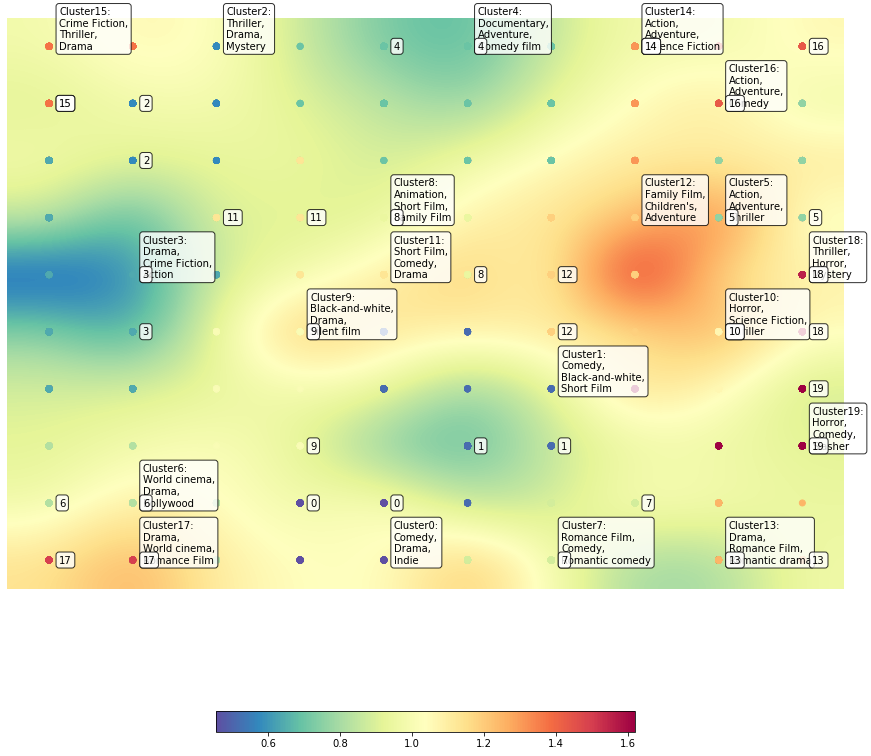

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [81]:
som.view_umatrix(figsize=(15,15), bestmatches=True, colorbar=True, labels=ulabels)

In [83]:
neighbors_noise=[1/5, 2/6, 2/4, 1/5, 1/5, 1/4, 2/4, 0/3, 0/3, 2/5, 0, 1/3, \
                    0/4, 1/2, 0/3, 0/2, 0/2, 1/2, 1/3, 1/2]

neighbors_test(neighbors_noise, num_clusters)

Ποσοστό θορύβου μεταξύ των γειτονικών ομάδων: 23.75%


### **Συμπεράσματα και Αποφάσεις**

Από τα παραπάνω προκύπτουν:

* Πλήθος bmus: 96
* Ποσοστό εξειδικευμένων ομάδων: 0.0%
* Ποσοστό γενικευμένων ομάδων: 0.0%
* Ποσοστό επιτρεπτών συγχωνεύσεων: 55.00000000000001%
* Ποσοστό ομάδων που πέρασαν το τεστ των Top5 κατηγοριών: 85.0%
* Ποσοστό θορύβου μεταξύ των γειτονικών ομάδων: 23.75%

Αυτό που θέλουμε είναι μείωση των επιτρεπτών σγχωνεύσεων και του θορύβου και αύξηση των ομάδων που περνούν το τεστ κατηγοριών.

* Η μείωση του αριθμού ομάδων γενικεύει το σύστημα και μπορεί να μειώσει τις επιτρεπτές συγχωνεύσεις.
* Η αύξηση του μεγέθους του χάρτη μπορεί να οδηγήσει σε  μικρότερο θόρυβο.
* Η αύξηση του πλήθος των ομάδων που περνούν το τεστ των τοπ 5 κατηγοριών (αν και ήδη μεγάλο σκορ) μπορεί να επέλθει μέσω της βελτιστοποίησης της διανυσματικής απεικόνισης του corpus.

## **Βελτιστοποίηση Συστήματος**



### **Βελτιστοποίηση αναπαράστασης Tf Idf**

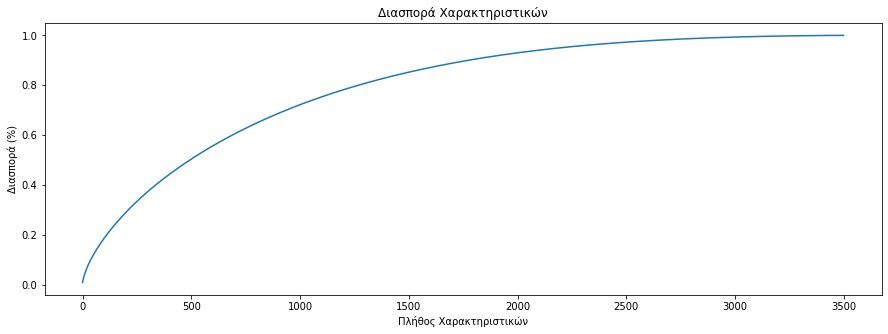

In [99]:
# Χρήση PCA για την εξαγωγή ποιότητας των επιλεγμένων χαρακτηριστικών

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA()

pca = PCA().fit(corpus_tf_idf)
plt.figure(figsize=(15,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Πλήθος Χαρακτηριστικών')
plt.ylabel('Διασπορά (%)')
plt.title('Διασπορά Χαρακτηριστικών')
plt.show()

Παρατηρούμε ότι με τη μείωση των χαρακτηριστικών στα 2500 δεν παρουσιάζεται σημαντική πτώση της πληροφορίας. Μπορούμε επομένως να μειώσουμε τα χαρακτηριστικά-λέξεις που εξάγονται από το 1ο ζητούμενο. Παρόλα αυτά υπήρχε αρνητική επίδραση στη σημασιολογική απεικόνιση των ταινιών στον χάρτη. Και αυτό συνέβη, καθώς το test των top 5 κατηγοριών έβγαλε το ίδιο ποσοστό με τα 3500 χαρακτηριστικά. Όμως παρατηρήθηκε ότι ο θόρυβος μεταξύ ομάδων αυξήθηκε στα $\approx 80\%$ που σημαίνει ότι ουσιαστικά οι ομάδες στο χάρτη γειτνίαζαν με σημασιολογικά απόμακρες ομάδες μπερδεύοντας την κατανομή.

In [0]:
opt_corpus_tf_idf = corpus_tf_idf[:, :2500]

In [110]:
opt_final_set = build_final_set(opt_corpus_tf_idf)
print(opt_final_set.shape)

(5000, 2822)


### **SOM init&train / SOM load**

Για να βρούμε την βέλτιστη σημασιολογική απεικόνιση των ταινιών πειραματιστήκαμε με πολλές παραμέτρους.

* Κατά την αρχικοποίηση **(somoclu.Somoclu)**:

  1. Τις διαστάσεις του χάρτη (n_columns, n_rows) $\rightarrow_{opt}$ (30, 30). Αυξήθηκε το top5 κατηγορίες σκορ και μειώθηκε ο θόρυβος.
  2. To gridtype $\rightarrow_{opt}$ rectangular.
  3. Το compactsupport $\rightarrow_{opt}$ False, παρατηρήθηκαν καλύτερες γειτονιές ταινιών.
  4. neighborhood $\rightarrow_{opt}$ gaussian, αν και τελικά δεν είχε νόημα καθώς η bubble αποτελεί μια προσέγγιση της gaussian.
  5. std_coeff $\rightarrow_{opt}$ 0.5 : default λειτουργία δηλαδή. Δοκιμάστηκαν οι τιμές 0.8 και 0.3 ως αντικατοπτριστικές για ακραίες τιμές οι οποίες παρουσιάσαν καλά αποτελέσματα μονο για χάρτη μεγέθους (10, 10).
  6. initialization $\rightarrow_{opt}$ None, δοκιμάστηκε η pca λειτουργία η οποία όμως επέστρεψε πολύ χειρότερα αποτελέσματα, καθώς σημασιολογικά άσχετες μεταξύ τους ομάδες γειτνίαζαν.

* Κατά την εκπαίδευση **(som.train)**:

  1. Για το epochs $\rightarrow_{opt}$ 100 αν και δεν πειραματιστήκαμε πολύ παρά μόνο δύο φορές που θέλαμε να εξάγουμε γρήγορα κάποια συμπεράσματα και εκπαιδεύσαμε στις 30 και 50 εποχές. Παρατηρήθηκε ότι με περισσότερες εποχές παρουσιάζονται καλύτερα τα σύνορα μεταξύ των ομάδων στο χάρτη.
  2. Για το radiuscooling $\rightarrow_{opt}$ linear (default). Δοκιμάστηκε και η exponential πολιτική η οποία λειτούργησε καλά μόνο για μικρού μεγέθους χάρτες. Για τον (30, 30) υπήρχε μεγάλη σύγχυση ειδών μέσα στις ίδιες τις ομάδες.
  3. Για το scalecooling $\rightarrow_{opt}$ linear (default) για τους ίδιους λόγους με παραπάνω.
  4. Για το scaleN $\rightarrow_{opt}$ 0.01. Δοκιμάστηκαν οι τιμές 0.3 και 1.0 αλλά και οι δύο επέστρεψαν χειρότερες ομαδοποιήσεις κατηγοριών ταινιών.


In [0]:
# Ορίζουμε το μέγεθος του χάρτη
cols, rows = 30, 30

In [0]:
# Αρχικοποιούμε το SOM
som = somoclu.Somoclu(n_columns=cols, n_rows=rows, maptype='planar', compactsupport=False)

In [113]:
# Εκπαιδεύουμε το SOM
%time som.train(final_set, epochs=100)

CPU times: user 1h 42min 43s, sys: 12.4 s, total: 1h 42min 55s
Wall time: 51min 38s


In [1]:
# Κάνουμε load την καλύτερη υλοποίηση SOM επειδή έχουν γίνει πολλές δοκιμές
# μέσω του Google Drive λόγω του καθαρισμού των αρχείων
# από το Colab μετά την επανεκκίνηση ενός session
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
som = joblib.load('/content/drive/My Drive/som.pkl')

### **SOM clusters**

In [0]:
# Ορίζουμε το πλήθος των ομάδων 
opt_num_clusters = 20

In [0]:
# Αρχικοποιούμε τον αλγόριθμος της ομαδοποίησης
opt_k_means = KMeans(n_clusters=opt_num_clusters, random_state=10, n_jobs=-1)

In [0]:
# Εφαρμόζουμε τον αλγόριθμο ομαδοποίησης στα bmus του χάρτη
som.cluster(algorithm=opt_k_means)

In [61]:
print(som.clusters)

[[14 14 14 14 14 14 15 15 15 15 12 12 12 12 12 12 12  1  1  1  1  1  1  1
   1  0  0  0  1  1]
 [14 14 14 14 14 14 15 15 15 15 12 12 12 12 12 12 12  1  1  1  1  1  1  1
   1  0  0  1  1  1]
 [14 14 14 14 14 14 15 15 15 12 12 12 12 12 12 12 12  1  1  1  1  1  1  1
   1  1  1  1  1  1]
 [14 14 14 14 14 14 15 15  5 12 12 12 12 12 12 12 12  1  1  1  1  1  1  1
   1  1 13 13 13 13]
 [14 14 14 14 14 15 15  5  5  5 12 12 12 12 12 12  1  1  1  1  1  1  1  1
   1  1 13 13 13 13]
 [14 14 15 15 15 15 15  5  5  5  5  5 12 12 12  1  1  1  1  1  1  1  1  1
   1 13 13 13 13 13]
 [15 15 15 15 15 15  5  5  5  5  5  5  5  5  1  1  1  1  1  1  1  1  1  1
   1 13 13 13 13 13]
 [15 15 15 15 15  5  5  5  5  5  5  5  5  5  5  1  1 19 19 19 19  1  1  1
   1 13 13 13 13 13]
 [15 15 15 15 15 15  5  5  5  5  5  5  5  5  1  1  1 19 19 19 19 19  1  1
   1 13 13 13 13 13]
 [15 15 15 15 15  5  5  5 16 16 16  5  5  5  1  1  1  1 19 19 19 19  1  1
  13 13 13 13 13 13]
 [15 15 15 18 18 18 18 16 16 16 16 16  5  5  5  1 

### **Αναφορές και Έλεγχος**

In [62]:
print("Πλήθος bmus:", np.unique(som.bmus, axis=0).shape[0])

Πλήθος bmus: 654


In [63]:
print_cluster_neurons_movies_report(som.bmus, som.clusters, opt_num_clusters)

Cluster 0
********************
* Αριθμός BMUs: 24 *
********************
Νευρώνας(0, 25) με 6 ταινίες
Νευρώνας(0, 26) με 17 ταινίες
Νευρώνας(0, 27) με 8 ταινίες
Νευρώνας(1, 25) με 24 ταινίες
Νευρώνας(1, 26) με 0 ταινίες
Νευρώνας(23, 5) με 10 ταινίες
Νευρώνας(24, 3) με 2 ταινίες
Νευρώνας(24, 4) με 1 ταινίες
Νευρώνας(24, 5) με 8 ταινίες
Νευρώνας(24, 6) με 0 ταινίες
Νευρώνας(25, 2) με 5 ταινίες
Νευρώνας(25, 3) με 15 ταινίες
Νευρώνας(25, 4) με 1 ταινίες
Νευρώνας(25, 5) με 8 ταινίες
Νευρώνας(25, 6) με 7 ταινίες
Νευρώνας(25, 7) με 6 ταινίες
Νευρώνας(26, 3) με 0 ταινίες
Νευρώνας(26, 4) με 9 ταινίες
Νευρώνας(26, 5) με 0 ταινίες
Νευρώνας(26, 6) με 3 ταινίες
Νευρώνας(26, 7) με 4 ταινίες
Νευρώνας(27, 6) με 2 ταινίες
Νευρώνας(27, 9) με 1 ταινίες
Νευρώνας(27, 10) με 3 ταινίες
************************
* Αριθμός ταινιών: 140 *
************************

Cluster 1
*********************
* Αριθμός BMUs: 114 *
*********************
Νευρώνας(0, 17) με 19 ταινίες
Νευρώνας(0, 18) με 6 ταινίες
Νευρώνας(0, 19)

In [64]:
ulabels = all_tests(som.bmus, som.clusters, opt_num_clusters, 2)

Cluster 0
^^^^^^^^^^

Action 194
Adventure 126
Drama 118
War film 55
Black-and-white 26

Cluster 1
^^^^^^^^^^

Drama 788
Black-and-white 86
Indie 52
Family Film 48
Family Drama 40

Cluster 2
^^^^^^^^^^

Action 132
Documentary 106
Comedy film 95
Romance Film 90
Western 61

Cluster 3
^^^^^^^^^^

Short Film 141
Drama 23
Documentary 12
Comedy 9
Comedy film 8

Cluster 4
^^^^^^^^^^

Thriller 284
Drama 121
Mystery 112
Psychological thriller 75
Crime Thriller 69

Cluster 5
^^^^^^^^^^

Comedy 165
Drama 159
Comedy-drama 59
Indie 40
Black comedy 19

Cluster 6
^^^^^^^^^^

Action 183
Adventure 105
Comedy 85
Crime Fiction 30
Western 22

Cluster 7
^^^^^^^^^^

Children's 105
Family Film 96
Family 73
Adventure 63
Animation 56

Cluster 8
^^^^^^^^^^

Horror 390
Thriller 114
Science Fiction 95
Slasher 67
Supernatural 46

Cluster 9
^^^^^^^^^^

Comedy 350
Parody 51
Family Film 36
Indie 32
Black comedy 28

Cluster 10
^^^^^^^^^^

Adventure 158
Action 92
Fantasy 67
Science Fiction 52
Family Film 24

Cluster 11

In [69]:
top5_categories_passed = [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
top5_categories_test(top5_categories_passed, opt_num_clusters)

Ποσοστό ομάδων που πέρασαν το τεστ των Top5 κατηγοριών: 90.0%


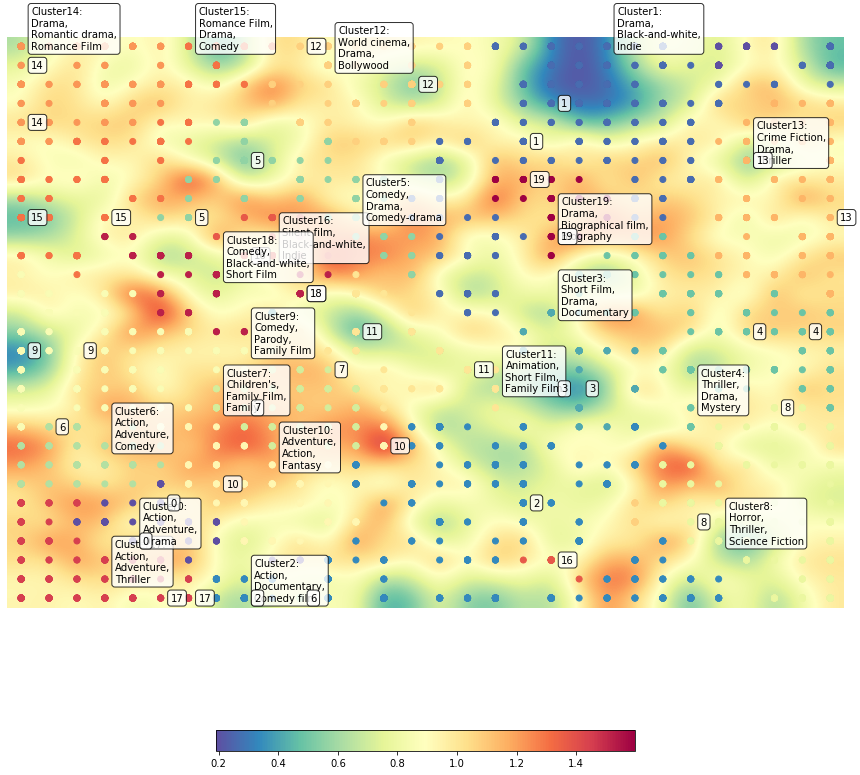

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [65]:
som.view_umatrix(figsize=(15,15), bestmatches=True, colorbar=True, labels=ulabels)

In [67]:
neighbors_noise=[0/4, 0/3, 1/4, 1/5, 0/3, 1/4, 0/3, 0/3, 1/2, 1/4, 0/5, 2/5, \
                    0/3, 0/2, 0/2, 0/3, 0/3, 0/3, 0/4, 0/2]

neighbors_test(neighbors_noise, opt_num_clusters)

Ποσοστό θορύβου μεταξύ των γειτονικών ομάδων: 9.25%


### **Συμπεράσματα και Αποφάσεις**

Από τα παραπάνω προκύπτουν:

* Πλήθος bmus: 654
* Ποσοστό εξειδικευμένων ομάδων: 5.0%
* Ποσοστό γενικευμένων ομάδων: 0.0%
* Ποσοστό επιτρεπτών συγχωνεύσεων: 50.0%
* Ποσοστό ομάδων που πέρασαν το τεστ των Top5 κατηγοριών: 90.0%
* Ποσοστό θορύβου μεταξύ των γειτονικών ομάδων: 9.25%

Οι τιμές αυτές αποτελούν τα καλύτερα αποτελέσματα που επιτεύχθηκαν με βάση τη διαδικασία της βελτιστοποίησης που περιγράφθηκε στην αρχή της ενότητας. Καταφέραμε να μειώσουμε τον αριθμό των συγχωνεύσεων κατα 5%, το ποσοστό του θορύβου κατά 14.5% και να αυξήσουμε το σκορ του Top5 κατηγοριών στα 90%.
Ουσιαστικά πετύχαμε τους στόχους που θέσαμε πριν την βελτιστοποίηση της σημασιολογικής απεικόνισης. Δυστυχώς, αυξήθηκε το ποσοστό των εξειδικευμένων ομάδων κατα τη διαδικασία αυτή αλλά αποτελεί ένα καλό αντίτιμο για τις τιμές που λάβαμε.

In [82]:
joblib.dump(som, 'som.pkl')

['som.pkl']